In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

 train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
* test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of * Transported for the passengers in this set.

sample_submission.csv - A submission file in the correct format.

* PassengerId - Id for each passenger in the test set.
* Transported - The target. For each passenger, predict either True or False.

In [26]:
#test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
test = pd.read_csv('test.csv')
test.head()

# Separate test PassengerId (will need it for submission)
test_pass_id = test.PassengerId.copy()

In [4]:
#train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
train = pd.read_csv('train.csv')
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
X = train.drop(columns = 'Transported')
y = train[['Transported']]

In [6]:
X.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


In [7]:
# separando os valores de cabine
X[['deck', 'num', 'side']] = X['Cabin'].str.split(pat = '/', expand = True)
X.drop(columns = 'Cabin', inplace = True)

#estudar como jogar usso num pipeline

In [8]:
X

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,deck,num,side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,A,98,P
8689,9278_01,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,G,1499,S
8690,9279_01,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,G,1500,S
8691,9280_01,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,E,608,S


In [9]:
#substiutior os False and Trues por 0 e 1
X.replace({ False : 0,
                 True: 1}, inplace = True)

y.replace({ False : 0,
                 True: 1}, inplace = True)




C:\Users\andre\AppData\Local\Temp\ipykernel_20400\2955069841.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.replace({ False : 0,


In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   float64
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   float64
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Name          8493 non-null   object 
 12  deck          8494 non-null   object 
 13  num           8494 non-null   object 
 14  side          8494 non-null   object 
dtypes: float64(8), object(7)
memory usage: 1018.8+ KB


In [11]:
X.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
deck            199
num             199
side            199
dtype: int64

<Axes: xlabel='HomePlanet', ylabel='count'>

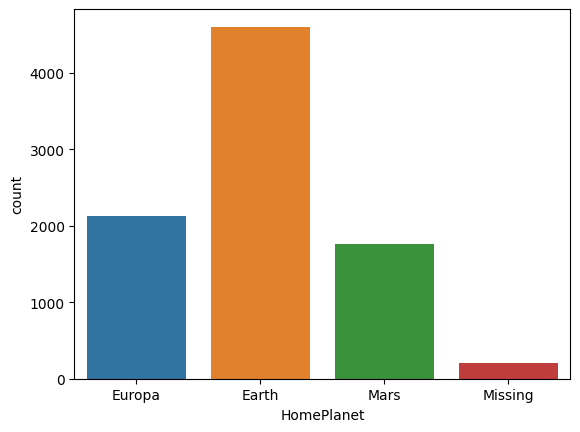

In [12]:

sns.countplot(data = X.fillna('Missing'), x = 'HomePlanet')
# Substituir missing por earth

<Axes: xlabel='CryoSleep', ylabel='count'>

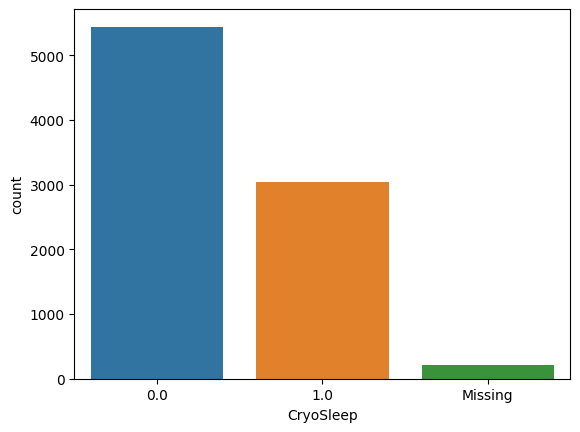

In [13]:

sns.countplot(data = X.fillna('Missing'), x = 'CryoSleep')
# Substituir missing por False

<Axes: xlabel='Destination', ylabel='count'>

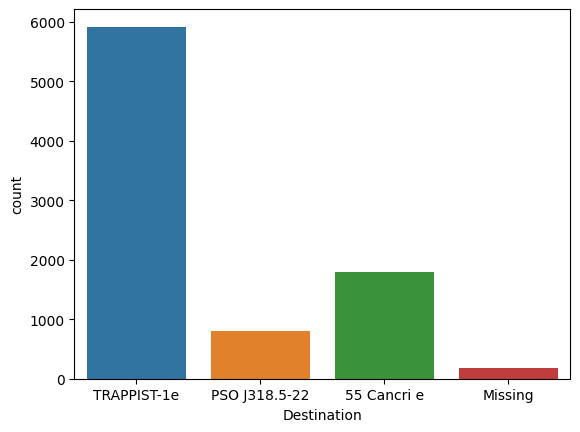

In [14]:

sns.countplot(data = X.fillna('Missing'), x = 'Destination')
# Substituir missing por False

In [15]:
# em uma primeira abordagem, vamos substituir todos os NaN pelos valores mais frequentes
# será ralizado dentro de um dataframe
X['num'] = pd.to_numeric(X['num'])
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   float64
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   float64
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Name          8493 non-null   object 
 12  deck          8494 non-null   object 
 13  num           8494 non-null   float64
 14  side          8494 non-null   object 
dtypes: float64(9), object(6)
memory usage: 1018.8+ KB


In [16]:
## Tive que remover as duas colunas abaixo pois estavam apresentando problemas no pipeline, depois vou investigar, mas acredito que deva ser por causa do inputer.
X.drop(columns = ['PassengerId', 'Name'], inplace = True)

In [17]:
# separando as colunas entre numéricas e categóricas
colunas_numericas = X.select_dtypes(include=np.number).columns
colunas_numericas


Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'num'],
      dtype='object')

In [18]:
colunas_categoricas = X.select_dtypes(include = 'object').columns
colunas_categoricas

Index(['HomePlanet', 'Destination', 'deck', 'side'], dtype='object')

# Estrutura do pipeline

In [19]:
# Preprocessamento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import svm



In [20]:
#Split de treino e teste
SEED = 123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

#preprocessor
numeric_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='most_frequent'))
      ,('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='most_frequent'))
      ,('encoder', OneHotEncoder()) #depois testar com OrdinalEncoder
])



numeric_features = colunas_numericas 
categorical_features = colunas_categoricas
preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, numeric_features)
   ,('categorical', categorical_transformer, categorical_features)
]) 

In [21]:
#Estruturando os pipelines


pipe_lr = Pipeline([('preprocessor', preprocessor),
                    ('LR', LogisticRegression(random_state = SEED))])
pipe_dt = Pipeline([('preprocessor', preprocessor),
                    ('DT',DecisionTreeClassifier(random_state = SEED))])
pipe_rf = Pipeline([('preprocessor', preprocessor),
                    ('RF',RandomForestClassifier(random_state = SEED))])
pipe_knn = Pipeline([('preprocessor', preprocessor),
                    ('KNN', KNeighborsClassifier())])
pipe_svm = Pipeline([('preprocessor', preprocessor),
                     ('SVM', svm.SVC(random_state = SEED))])
pipe_xgb = Pipeline([('preprocessor', preprocessor),
                     ('XGB', XGBClassifier(random_state = SEED))])

In [22]:
pipelines = [pipe_lr, pipe_dt, pipe_rf, pipe_knn, pipe_svm, pipe_xgb]
for pipe in pipelines:
  pipe.fit(X_train, y_train.values.ravel())

In [23]:
grid_dict = {0: 'Logistic Regression', 1: 'Decision Trees', 
             2: 'Random Forest', 3: 'K-Nearest Neighbors', 
             4: 'Support Vector Machines', 5: 'XGBoost'}
for i, model in enumerate(pipelines):
    print('{} Test Accuracy: {}'.format(grid_dict[i], model.score(X_test,y_test)))
    #print('{} Best Params: {}'.format(grid_dict[i], model.best_params_))

Logistic Regression Test Accuracy: 0.8105828220858896
Decision Trees Test Accuracy: 0.7645705521472392
Random Forest Test Accuracy: 0.8148006134969326
K-Nearest Neighbors Test Accuracy: 0.7948619631901841
Support Vector Machines Test Accuracy: 0.8159509202453987
XGBoost Test Accuracy: 0.8128834355828221


In [24]:
## Gerando o CSV de submissão:
# realizando as mudanças que fizemos no dataset original FORA do pipeline:

test[['deck', 'num', 'side']] = test['Cabin'].str.split(pat = '/', expand = True)
test.drop(columns = ['Cabin','PassengerId', 'Name'], inplace = True)
test['num'] = pd.to_numeric(test['num'])
test.replace({ False : 0,
                 True: 1}, inplace = True)

# gerando o modelo
svm_model = pipe_svm.fit(X_train, y_train)

# gerando y_previsto
y_previsto = svm_model.predict(test) 
y_previsto

c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [27]:
# Save predictions in the format used for competition scoring
output = pd.DataFrame({'PassengerId': test_pass_id,
                       'Transported': y_previsto.astype(bool)})

output.to_csv('submission.csv', index=False)